In [41]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import GPE_ensemble as GPE

from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion, 
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion

import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\xlabels_EP.txt',delim_whitespace=True,header=None)

In [43]:
y_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\ylabels.txt',delim_whitespace=True,header=None)

In [44]:
y_labels

,0
0,A_TAT
1,V_TAT


In [45]:
inputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_1 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/02/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_1 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = pd.DataFrame(inputData_0)
Y0 = pd.DataFrame(outputData_0)

X1 = pd.DataFrame(inputData_1)
Y1 = pd.DataFrame(outputData_1)

X0.columns=x_labels
X1.columns=x_labels

Y0.columns = y_labels
Y1.columns = y_labels

In [7]:
emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

0
1


In [8]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

In [9]:
X_test.shape[1]

6

In [10]:
a=np.random.choice(range(X_train.shape[0]),18,replace=False)

In [11]:
X_train.iloc[a]

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
101,0.659097,0.447478,5.16641,0.428337,0.380779,5.29749
166,0.778366,0.257570,7.13957,0.849156,0.461500,4.04885
171,0.762414,0.365481,5.22917,0.398149,0.294855,1.62742
176,0.474823,0.252514,5.58204,0.402236,0.324457,2.32006
62,0.703821,0.362013,6.88518,0.854891,0.449605,3.23572
72,0.753422,0.343359,8.28469,0.560605,0.428886,4.14714
163,0.664394,0.215038,7.46973,0.651242,0.310478,3.54209
64,0.687285,0.444615,2.04548,0.743850,0.261925,1.08205
20,0.723636,0.220040,5.39449,1.014100,0.299544,3.14231
131,0.764257,0.460028,3.40595,0.364433,0.263346,2.80397


In [12]:
X_train.shape

(162, 6)

In [13]:
m0 = emulator_0.predict(X_train.iloc[a])

In [14]:
y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())

In [15]:
delta_1 = GPE.ensemble(X_train.iloc[a],y_adjust,mean_func="linear",training_iter=500)

0
1


In [16]:
np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())

array([6.57733343, 1.55067206])

In [17]:
1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))

tensor([0.9880, 0.9968], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [18]:
p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 10
MSE = np.zeros((n,reps,2))
R2 = np.zeros((n,reps,2))
MSE_p = np.zeros((n,reps,2))
R2_p = np.zeros((n,reps,2))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulator_0.predict(X_train.iloc[a,:])
        y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())
        delta_1 = GPE.ensemble(X_train.iloc[a,:],y_adjust,mean_func="linear",training_iter=500)
        MSE[i,j] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())
        R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()
        
        delta_1p = GPE.ensemble(X_train.iloc[a,:],y_train.iloc[a],mean_func="linear",training_iter=500)
        MSE_p[i,j] += delta_1p.MSE(X_test,y_test).detach().numpy()
        R2_p[i,j] += delta_1p.R2(X_test,y_test).detach().numpy()

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [19]:
x = np.linspace(9,162,18)

In [20]:
x

array([  9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99.,
       108., 117., 126., 135., 144., 153., 162.])

In [21]:
MSE.mean(axis=1)[0]

array([10.51735234,  3.3430282 ])

In [22]:
MSE

array([[[ 4.59374885,  3.4253991 ],
        [ 6.88232508,  4.60474329],
        [ 7.29141527,  2.44245756],
        [15.45822805,  5.86810045],
        [15.74130701,  2.17809481],
        [16.76619897,  2.12583207],
        [10.32221433,  2.67219427],
        [ 8.49828905,  2.83304708],
        [10.09390316,  4.1242841 ],
        [ 9.52589362,  3.15612924]],

       [[ 6.16558624,  1.77387669],
        [ 3.60676459,  1.87644508],
        [ 3.55377333,  2.11928063],
        [ 3.47569548,  1.50752387],
        [ 9.91069739,  1.32119419],
        [ 4.65379937,  1.52850727],
        [ 3.70416197,  1.56700534],
        [ 5.06637623,  1.8811956 ],
        [ 5.19942452,  1.89308314],
        [ 2.57242346,  1.57371372]],

       [[ 3.63265687,  2.04714305],
        [ 4.13096377,  2.87884875],
        [ 2.49624607,  1.60634303],
        [ 2.78474978,  1.72287244],
        [ 2.05703723,  1.53761443],
        [ 3.78370395,  1.07289198],
        [ 2.68402813,  1.78263727],
        [ 5.76034542,  1

Text(0.5, 0, '$m$')

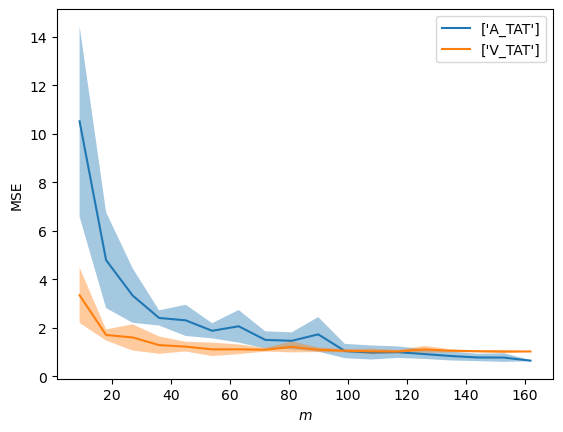

In [23]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')

In [24]:
MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0]

array([14.45100466,  6.76896842,  4.45550336,  2.7178102 ,  2.95190649,
        2.19059371,  2.7349809 ,  1.85495418,  1.81269615,  2.44265212,
        1.33757803,  1.27181706,  1.23247119,  1.11826378,  1.02017226,
        0.92736001,  0.95091308,  0.66822204])

In [25]:
MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0]

array([6.58370002, 2.8127721 , 2.20794241, 2.09260434, 1.66348443,
       1.56338011, 1.39056416, 1.14761364, 1.11546589, 1.01648505,
       0.7466344 , 0.69160779, 0.7577132 , 0.7152102 , 0.65189025,
       0.62512517, 0.59249768, 0.6206742 ])

In [26]:
delta_1p.MSE(X_test,y_test)/reps

tensor([0.0689, 0.2324], dtype=torch.float64, grad_fn=<DivBackward0>)

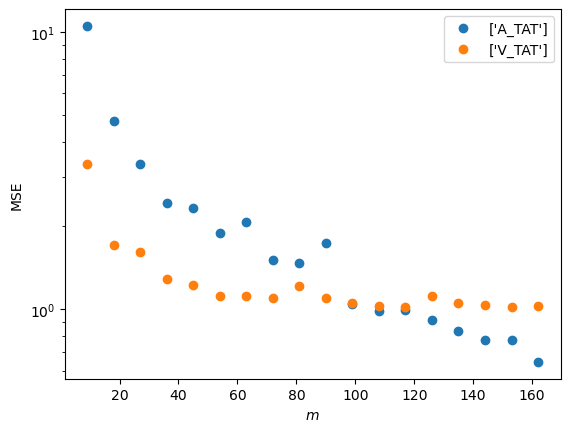

In [27]:
plt.plot(x,MSE.mean(axis=1),'o') 
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

In [28]:
np.hstack((MSE_p,MSE))

array([[[6.82041741e+02, 5.82211640e+01],
        [2.08250467e+03, 1.01621711e+02],
        [6.25645819e+02, 8.42012269e+01],
        [2.63674753e+03, 4.44372066e+02],
        [2.29323941e+03, 2.51942028e+02],
        [4.48476922e+03, 2.87796154e+02],
        [2.79964467e+03, 1.73983040e+02],
        [7.25130767e+02, 1.16365017e+02],
        [1.01041930e+03, 2.53169781e+02],
        [2.13421525e+03, 9.10068343e+01],
        [4.59374885e+00, 3.42539910e+00],
        [6.88232508e+00, 4.60474329e+00],
        [7.29141527e+00, 2.44245756e+00],
        [1.54582281e+01, 5.86810045e+00],
        [1.57413070e+01, 2.17809481e+00],
        [1.67661990e+01, 2.12583207e+00],
        [1.03222143e+01, 2.67219427e+00],
        [8.49828905e+00, 2.83304708e+00],
        [1.00939032e+01, 4.12428410e+00],
        [9.52589362e+00, 3.15612924e+00]],

       [[1.54122168e+02, 6.07101716e+01],
        [1.29793853e+02, 4.11271980e+01],
        [1.17614963e+02, 1.03116989e+02],
        [1.62953304e+02, 8.91322

In [29]:
MSE_p.mean(axis=1)[:,0]+MSE_p.std(axis=1)[:,0]

array([3.11073125e+03, 4.41765810e+02, 1.30700535e+02, 4.80202581e+01,
       2.19334007e+01, 1.45078398e+01, 1.18078235e+01, 6.82654356e+00,
       6.85328316e+00, 6.38240317e+00, 3.63381404e+00, 3.81226000e+00,
       3.05168473e+00, 3.02113874e+00, 2.62018195e+00, 1.45818609e+00,
       1.62281166e+00, 8.26760504e-01])

In [30]:
MSE_p

array([[[6.82041741e+02, 5.82211640e+01],
        [2.08250467e+03, 1.01621711e+02],
        [6.25645819e+02, 8.42012269e+01],
        [2.63674753e+03, 4.44372066e+02],
        [2.29323941e+03, 2.51942028e+02],
        [4.48476922e+03, 2.87796154e+02],
        [2.79964467e+03, 1.73983040e+02],
        [7.25130767e+02, 1.16365017e+02],
        [1.01041930e+03, 2.53169781e+02],
        [2.13421525e+03, 9.10068343e+01]],

       [[1.54122168e+02, 6.07101716e+01],
        [1.29793853e+02, 4.11271980e+01],
        [1.17614963e+02, 1.03116989e+02],
        [1.62953304e+02, 8.91322169e+01],
        [3.13380323e+02, 7.14747421e+01],
        [7.55284036e+02, 5.60567185e+01],
        [3.48831836e+02, 8.34160803e+01],
        [9.40698049e+01, 3.57193467e+01],
        [5.98908399e+01, 2.35845771e+02],
        [3.23364902e+02, 9.58300398e+01]],

       [[3.78474720e+01, 5.86594057e+01],
        [7.37801588e+01, 3.04129132e+01],
        [1.68595370e+02, 2.70037608e+01],
        [1.64106741e+01, 2.273

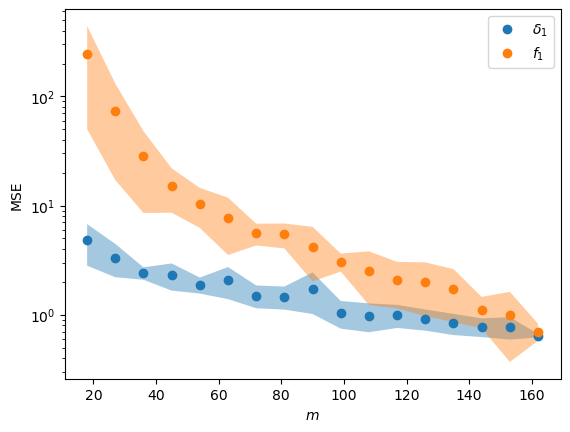

In [31]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[0,2]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

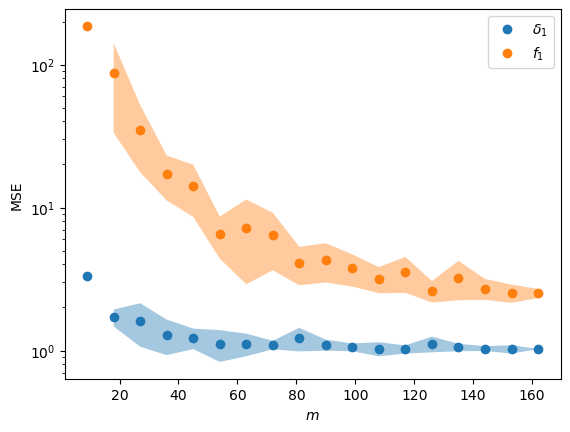

In [32]:
plt.plot(x,np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[:,[1,3]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

Text(0.5, 0, '$m$')

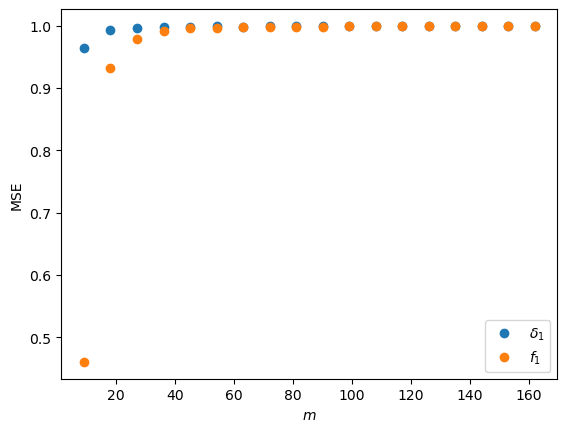

In [33]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[0,2]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')

Text(0.5, 0, '$m$')

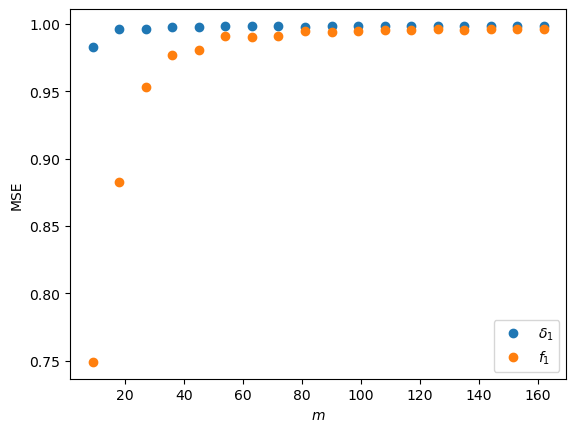

In [34]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[1,3]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')

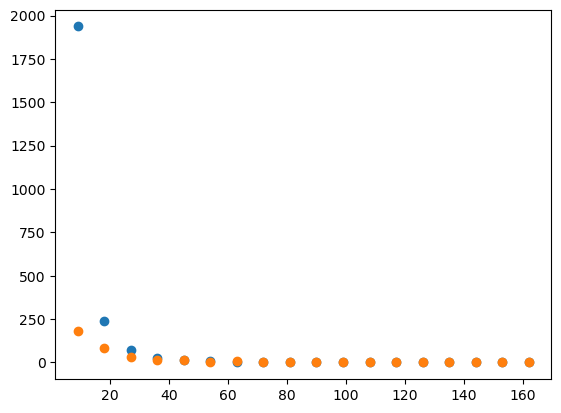

In [35]:
plt.plot(x,MSE_p.mean(axis=1)-MSE.mean(axis=1),'o')


Text(0.5, 0, '$m$')

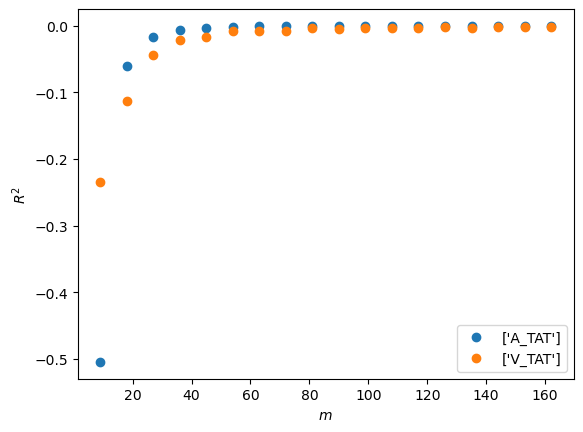

In [36]:
plt.plot(x,R2_p.mean(axis=1)-R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')

In [37]:
MSE_p

array([[[6.82041741e+02, 5.82211640e+01],
        [2.08250467e+03, 1.01621711e+02],
        [6.25645819e+02, 8.42012269e+01],
        [2.63674753e+03, 4.44372066e+02],
        [2.29323941e+03, 2.51942028e+02],
        [4.48476922e+03, 2.87796154e+02],
        [2.79964467e+03, 1.73983040e+02],
        [7.25130767e+02, 1.16365017e+02],
        [1.01041930e+03, 2.53169781e+02],
        [2.13421525e+03, 9.10068343e+01]],

       [[1.54122168e+02, 6.07101716e+01],
        [1.29793853e+02, 4.11271980e+01],
        [1.17614963e+02, 1.03116989e+02],
        [1.62953304e+02, 8.91322169e+01],
        [3.13380323e+02, 7.14747421e+01],
        [7.55284036e+02, 5.60567185e+01],
        [3.48831836e+02, 8.34160803e+01],
        [9.40698049e+01, 3.57193467e+01],
        [5.98908399e+01, 2.35845771e+02],
        [3.23364902e+02, 9.58300398e+01]],

       [[3.78474720e+01, 5.86594057e+01],
        [7.37801588e+01, 3.04129132e+01],
        [1.68595370e+02, 2.70037608e+01],
        [1.64106741e+01, 2.273

In [38]:
R2_p-R2

array([[[-1.83195487e-01, -6.26139772e-02],
        [-5.64088406e-01, -1.08314298e-01],
        [-1.58677150e-01, -1.05374814e-01],
        [-6.64606413e-01, -5.52140824e-01],
        [-5.66946738e-01, -3.32948514e-01],
        [-1.16514836e+00, -3.81543055e-01],
        [-7.46457658e-01, -2.24718448e-01],
        [-1.80969953e-01, -1.45920570e-01],
        [-2.51822007e-01, -3.18081715e-01],
        [-5.66398470e-01, -1.09159650e-01]],

       [[-3.21820960e-02, -7.75317688e-02],
        [-3.23698508e-02, -5.06513642e-02],
        [-2.90993459e-02, -1.32837924e-01],
        [-4.18181035e-02, -1.16990344e-01],
        [-5.96364193e-02, -9.39175725e-02],
        [-2.03342462e-01, -7.23554683e-02],
        [-9.28842252e-02, -1.09045019e-01],
        [-1.89591886e-02, -4.33435382e-02],
        [-9.10707352e-03, -3.12831463e-01],
        [-8.77943369e-02, -1.25736884e-01]],

       [[-6.83270480e-03, -7.33632481e-02],
        [-1.57200334e-02, -2.98001424e-02],
        [-4.50031932e-02, -3

Text(0.5, 0, '$m$')

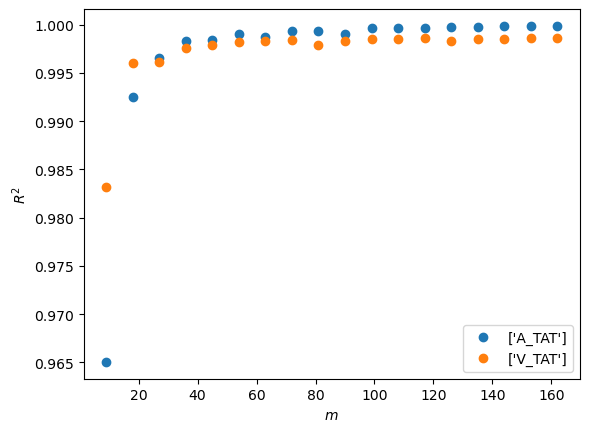

In [39]:
plt.plot(x,R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')

In [40]:
p

9

In [416]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,2))
R2 = np.zeros((n,m,2))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0.iloc[a,:],Y0.iloc[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train.iloc[b,:])
            y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[b].values) - m0).detach().numpy())
            delta_1 = GPE.ensemble(X_train.iloc[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()/reps

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


In [417]:
x

array([  9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99.,
       108., 117., 126., 135., 144., 153., 162.])

In [418]:
y = np.linspace(9,180,20)

In [419]:
y

array([  9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99.,
       108., 117., 126., 135., 144., 153., 162., 171., 180.])

In [420]:
xx,yy=np.meshgrid(x,y)

In [425]:
xx[1:,1:].shape

(19, 17)

In [438]:
level = 1

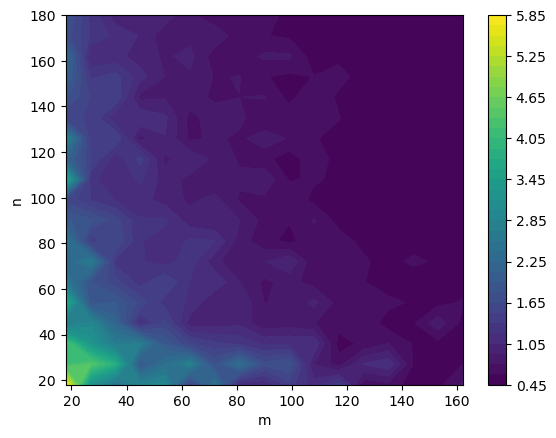

In [445]:
plt.contourf(xx[level:,level:],yy[level:,level:],MSE[level:,level:,1],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

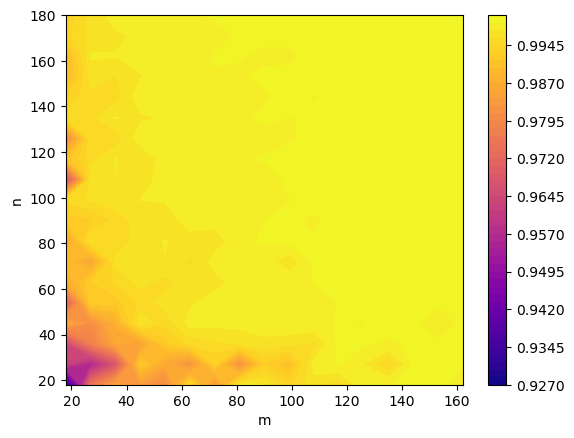

In [448]:
plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,1],origin='lower',levels=50,cmap='plasma')
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

ValueError: x and y can be no greater than 2D, but have shapes (20,) and (20, 18, 2)

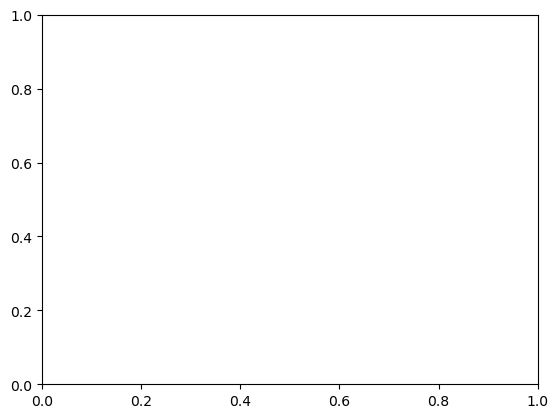

In [437]:
plt.plot(MSE) 
plt.legend(y_labels.values)
plt.ylabel('MSE')
plt.xlabel('$n$')

Text(0.5, 0, '$n$')

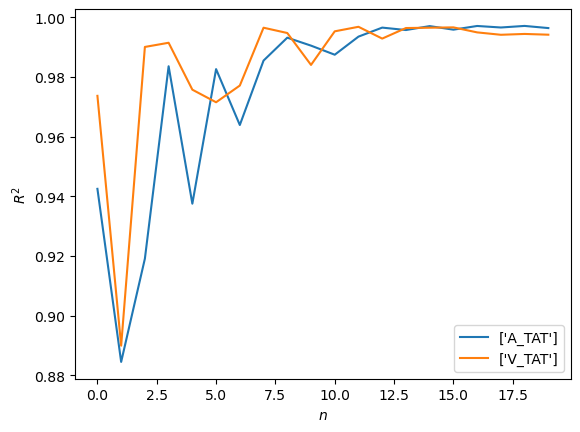

In [325]:
plt.plot(R2)
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$n$')

In [6]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [7]:
meshes.copy

<function list.copy()>

In [ ]:
t_size = 36
reps = 5
MSE = np.zeros((len(meshes),len(meshes)-1,2))
R2 = np.zeros((len(meshes),len(meshes)-1,2))
for i in (range(len(meshes))):
    val0 = meshes[i]
    
    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])
    
    inputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val0+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    X0 = pd.DataFrame(inputData_0)
    Y0 = pd.DataFrame(outputData_0)
    X0.columns = x_labels
    Y0.columns = y_labels
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

    
    
    for j in (range(len(meshes)-1)):
        val1 = meshes2[j]
        inputData_1 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val1+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
        outputData_1 = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val1+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

        X1 = pd.DataFrame(inputData_1)
        Y1 = pd.DataFrame(outputData_1)
        X1.columns = x_labels
        Y1.columns = y_labels
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train.iloc[a,:])
            y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())
            delta_1 = GPE.ensemble(X_train.iloc[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())/reps
            R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()/reps

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [409]:
MSE

array([[[44.55463331, 12.48656521],
        [17.92622688,  5.15833724],
        [ 7.62640622,  2.80905726],
        [ 5.07644527,  2.70281603],
        [ 5.246214  ,  1.60146339],
        [ 5.32124002,  2.41849939],
        [ 4.55666744,  1.48807741],
        [ 1.92135252,  1.23705929],
        [ 2.00908828,  1.14296049],
        [ 2.87102417,  0.9798143 ],
        [ 2.25686773,  1.48637332],
        [ 1.76600875,  0.59752404],
        [ 1.93448489,  0.62956682],
        [ 1.29456654,  0.54854626],
        [ 1.62995983,  1.02670357],
        [ 2.436825  ,  0.51261671],
        [ 1.49343461,  0.47457328],
        [ 1.20447589,  0.48499195]],

       [[26.82143591,  7.92571611],
        [16.85561235,  4.03501625],
        [10.9082474 ,  4.2584192 ],
        [ 5.92937177,  3.33507382],
        [ 6.56181224,  2.29050729],
        [ 6.28407867,  1.59865345],
        [ 7.73829181,  2.23406627],
        [ 4.27066967,  1.39559364],
        [ 5.29380748,  1.12518597],
        [ 2.52395268,  0.8

In [300]:
MSE.mean(axis=1)

array([[3.26187831, 1.79298624],
       [3.2801396 , 2.04670276],
       [2.46450089, 1.79957511],
       [2.61963692, 1.92974022],
       [2.99263129, 2.23654112],
       [2.68465234, 1.73536895],
       [3.33079312, 1.58068215],
       [3.23262693, 1.85341049],
       [2.85003875, 2.29282128],
       [3.18671227, 1.93067693],
       [2.39333175, 1.61376046],
       [2.65521918, 1.81663752],
       [3.33016686, 2.23788735],
       [2.80335246, 1.80253865],
       [3.21383719, 2.08631101],
       [2.66958526, 1.7408499 ],
       [3.3304454 , 1.61397494],
       [2.64060614, 1.57150698]])

Text(0.5, 0, 'Mesh')

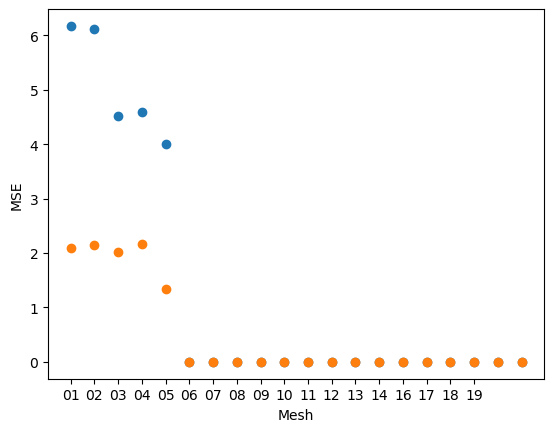

In [410]:
plt.plot(MSE.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('MSE')
plt.xlabel('Mesh')

In [79]:
y_labels

,0
0,A_TAT
1,V_TAT


NameError: name 'meshes' is not defined

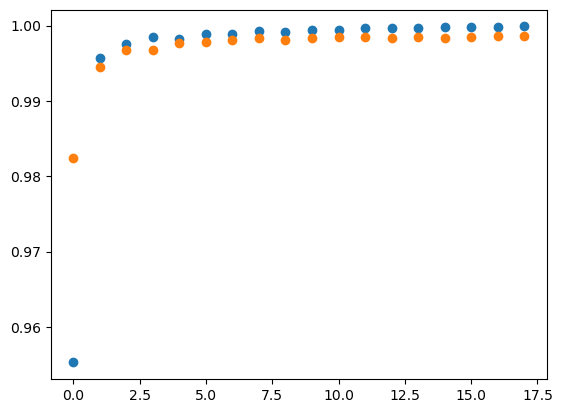

In [80]:
plt.plot(R2.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('$R^2$')
plt.xlabel('$m$')
plt.legend(y_labels)

In [225]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.380213, 0.799439]
[0.200232, 0.499533]
[1.21794, 8.37386]
[0.301329, 1.02696]
[0.201551, 0.497432]
[1.00518, 5.67874]


In [226]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=x_labels)

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_15932\145593949.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [229]:
data1

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
0,0.380827,0.312908,4.422031,0.654578,0.366395,4.950778
1,0.481540,0.312908,4.422031,0.654578,0.366395,4.950778
2,0.380827,0.376042,4.422031,0.654578,0.366395,4.950778
3,0.380827,0.312908,6.204023,0.654578,0.366395,4.950778
4,0.380827,0.312908,4.422031,0.788508,0.366395,4.950778
...,...,...,...,...,...,...
14331,0.429546,0.209731,7.881192,0.624816,0.349058,5.142467
14332,0.429546,0.209731,7.762392,0.556079,0.349058,5.142467
14333,0.429546,0.209731,7.762392,0.624816,0.388066,5.142467
14334,0.429546,0.209731,7.762392,0.624816,0.349058,4.079050


In [251]:
Ymean_A=delta_1.predict(data1)

In [252]:
Si = []
for i in range(2):
    Si.append(sobol.analyze(problem, Ymean_A[:,i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000061  0.000005
(k_ventricles,)   0.006439  0.000486
(k_FEC,)          0.002398  0.000206
(CV_atria,)       0.947955  0.057482
(k_atria,)        0.007983  0.000645
(k_BB,)           0.035140  0.003036
                        S1   S1_conf
(CV_ventricles,)  0.000054  0.000683
(k_ventricles,)   0.006435  0.006865
(k_FEC,)          0.002433  0.003947
(CV_atria,)       0.948018  0.073635
(k_atria,)        0.007970  0.008294
(k_BB,)           0.035140  0.019879
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.486321  0.040826
(k_ventricles,)   0.035319  0.004204
(k_FEC,)          0.425205  0.040547
(CV_atria,)       0.037762  0.003641
(k_atria,)        0.020304  0.001789
(k_BB,)           0.048147  0.005480
                        S1   S1_conf
(CV_ventricles,)  0.486634  0.055083
(k_ventricles,)   0.025084  0.016084
(k_FEC,)          0.365856  0.047679
(CV_atria,)       0.037353

In [253]:
nMod = 2
SiA_first=np.zeros((nDim,nMod))
SiA_total=np.zeros((nDim,nMod))

for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    SiA_first[:,i] =  first_Si.iloc[:,0]
    SiA_total[:,i] =  total_Si.iloc[:,0]


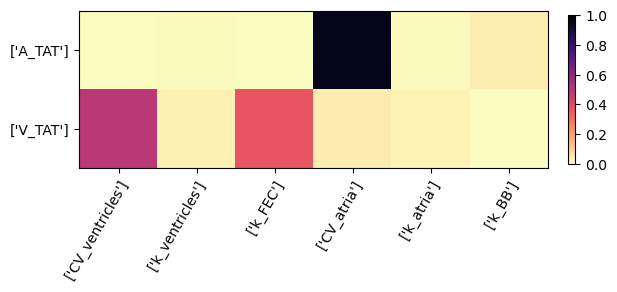

In [254]:
inputs = x_labels.values.tolist()
outputs = y_labels.values.tolist()
fig, ax = plt.subplots()
im = ax.imshow(SiA_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Distance simulation results

In [46]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\same_X\xlabels_EP.txt',delim_whitespace=True,header=None)

In [47]:
inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/same_X/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
inputData = pd.DataFrame(inputData)

In [48]:
inputData.columns=x_labels

In [49]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [50]:
d=[]
for val in meshes:
    d.append(pd.DataFrame(pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/same_X/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values,columns=['A_TAT','V_TAT']))

In [51]:
np.array(d).shape

(18, 180, 2)

In [52]:
np.array(d)[0:1,:10,0].T

array([[122.17 ],
       [344.156],
       [121.403],
       [165.463],
       [236.003],
       [215.851],
       [146.807],
       [303.375],
       [242.452],
       [154.642]])

In [53]:
np.array(d)[1:,:10,0].T

array([[ 92.1714,  88.244 ,  85.6108,  79.4421,  80.5874,  80.5269,
         78.327 ,  83.8367, 102.9   ,  96.2141,  72.4446,  91.4856,
         92.5334,  77.0678,  92.1445,  71.1917,  68.4627],
       [271.855 , 256.528 , 246.696 , 229.904 , 226.737 , 223.398 ,
        214.155 , 229.562 , 289.18  , 272.789 , 206.326 , 266.187 ,
        262.413 , 220.837 , 259.882 , 198.642 , 201.555 ],
       [100.9   ,  91.258 ,  86.587 ,  81.1279,  76.5798,  76.0823,
         74.3034,  81.6747,  98.4956,  96.7417,  73.1786,  93.1645,
         93.1445,  76.8222,  89.8862,  69.8923,  71.1007],
       [130.977 , 125.36  , 121.907 , 113.008 , 111.484 , 105.198 ,
        103.231 , 115.022 , 143.27  , 133.531 , 100.26  , 131.088 ,
        129.75  , 107.079 , 126.359 ,  95.0423, 100.978 ],
       [194.76  , 188.949 , 180.281 , 169.68  , 160.461 , 160.004 ,
        157.097 , 170.86  , 209.465 , 191.31  , 149.774 , 185.992 ,
        191.579 , 157.689 , 178.638 , 139.986 , 149.467 ],
       [164.424 , 157.197

Text(0, 0.5, 'A_TAT')

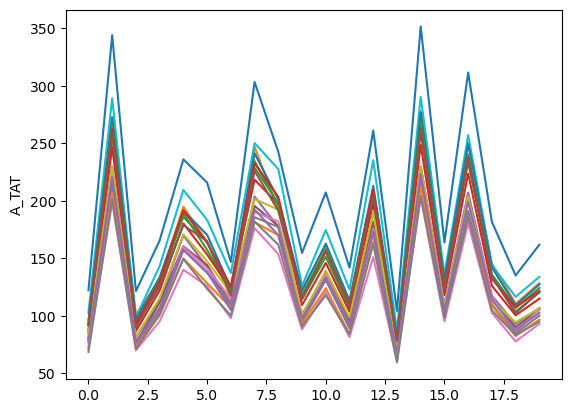

In [126]:
plt.plot(np.array(d)[:,0:20,0].T)
plt.ylabel('A_TAT')

In [66]:
np.array(d)[10,:,0].T.shape

(180,)

In [296]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.log(np.array(d)[0,:,0].T.reshape(-1, 1)),
    np.log(np.array(d)[1,:,0].T.reshape(-1, 1)) ,
    test_size=0.1,
    random_state=seed
)

In [106]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train,y_train )

In [107]:
reg.score(X_test,y_test)

0.9738653256609395

In [108]:
print(reg)

LinearRegression()


In [109]:
reg.coef_

array([[1.02385342]])

In [110]:
reg.intercept_

array([-0.62468786])

In [278]:
coeffs = np.zeros(17)
inter = np.zeros(17)
scores = np.zeros(17)
for i in range(17):
    # split original dataset in training, validation and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        
        np.log(np.array(d)[i+1,:,1].T.reshape(-1, 1)) ,
        np.log(np.array(d)[0,:,1].T.reshape(-1, 1)),
        test_size=0.1,
        random_state=seed
    )
    reg = LinearRegression().fit(X_train,y_train )
    coeffs[i]=reg.coef_
    inter[i]=reg.intercept_
    scores[i]=1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

In [279]:
1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

0.9759187427249034

In [280]:
meshes2 = meshes.copy()
meshes2.remove(meshes[0])
     

Text(0.5, 0, 'Mesh')

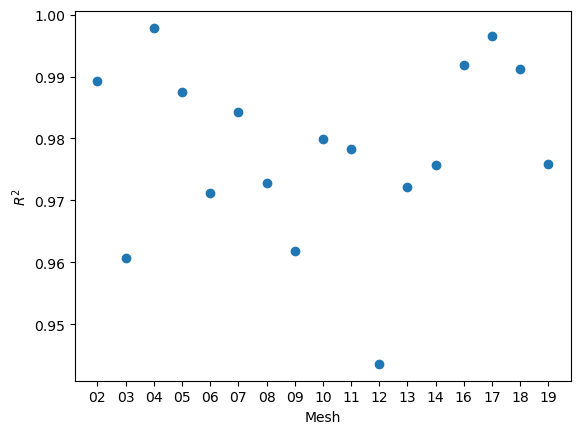

In [281]:
plt.plot(scores,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('$R^2$')
plt.xlabel('Mesh')

Text(0.5, 0, 'Mesh')

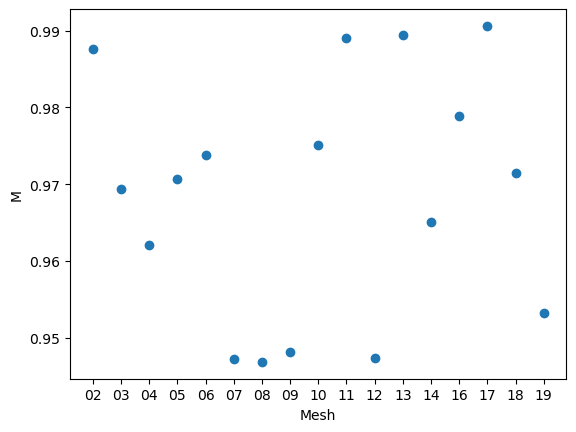

In [276]:
plt.plot(coeffs,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('M')
plt.xlabel('Mesh')

Text(0.5, 0, 'Mesh')

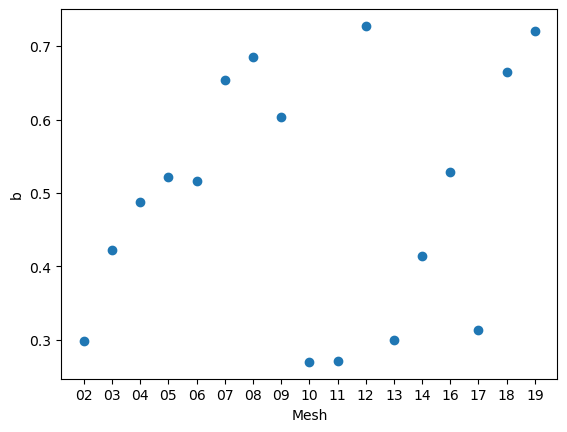

In [277]:
plt.plot(inter,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('b')
plt.xlabel('Mesh')

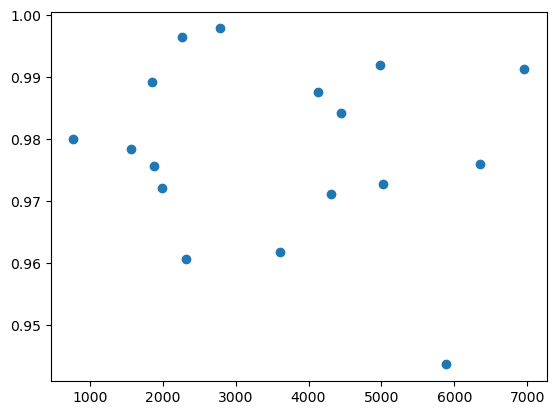

In [271]:
plt.scatter(distance.iloc[:,0],scores)

In [218]:
162/18

9.0

In [320]:
x=np.linspace(1,145,17)

In [321]:
x

array([  1.,  10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91.,
       100., 109., 118., 127., 136., 145.])

In [322]:
X_train

array([[4.74375753],
       [5.46384452],
       [4.85484661],
       [5.70452553],
       [5.0437412 ],
       [4.96152908],
       [4.71509129],
       [5.20189457],
       [5.68729395],
       [5.40129805],
       [5.15227952],
       [5.1087476 ],
       [5.34119485],
       [5.40710899],
       [5.83608186],
       [4.93675191],
       [5.3345191 ],
       [5.33459143],
       [4.93860209],
       [6.00761099],
       [5.53118944],
       [4.77900584],
       [5.44028991],
       [5.39701272],
       [5.33371347],
       [5.21378836],
       [5.41686455],
       [4.68140874],
       [5.75853262],
       [5.29951665],
       [4.91586297],
       [5.72502198],
       [5.00010673],
       [5.61549028],
       [5.11205405],
       [5.55228882],
       [4.91543044],
       [4.80541352],
       [4.95338746],
       [5.7837698 ],
       [4.592322  ],
       [5.33071679],
       [4.96962578],
       [5.17005777],
       [5.23872659],
       [5.56487667],
       [4.87302703],
       [5.581

In [323]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.log(np.array(d)[0,:,0].T.reshape(-1, 1)),
    np.log(np.array(d)[1,:,0].T.reshape(-1, 1)) ,
    test_size=0.1,
    random_state=seed
)

In [328]:
coeffs = np.zeros(17)
inter = np.zeros(17)
scores = np.zeros(17)
for i in range(17):
    # split original dataset in training, validation and testing sets
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_train,
        y_train,
        test_size=int(162-x[i]),
        random_state=seed
    )
    reg = LinearRegression().fit(X_train2,y_train2 )
    coeffs[i]=reg.coef_
    inter[i]=reg.intercept_
    scores[i]=1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

Text(0.5, 0, 'Training Data Size')

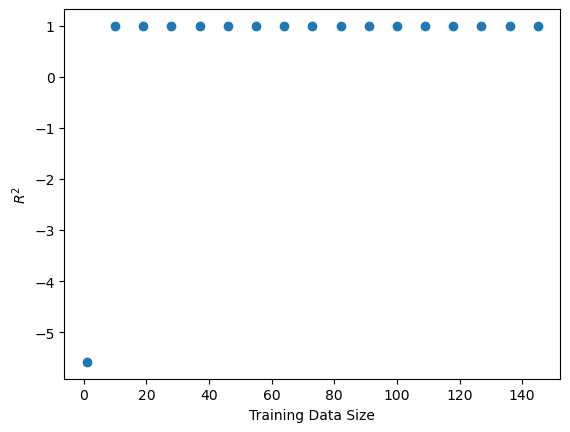

In [329]:
plt.plot(x,scores,'o')

plt.ylabel('$R^2$')
plt.xlabel('Training Data Size')

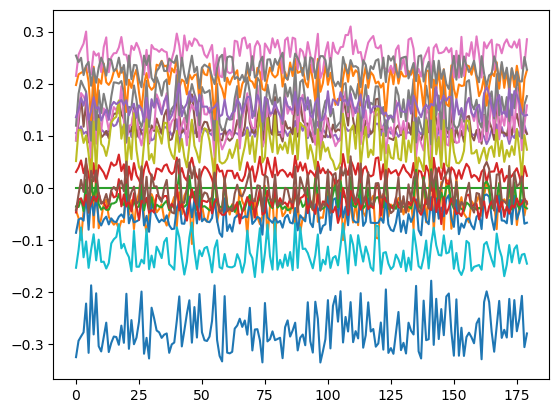

In [226]:
plt.plot(np.log(np.array(d)[2:3,:,0].T)-np.log(np.array(d)[:,:,0].T))


In [60]:
len(d)

18

In [ ]:
plt.plot(d)

In [74]:
((d[0]-d[1])**2).mean(axis=0)

A_TAT    1849.158453
V_TAT      61.114784
dtype: float64

In [69]:
import scipy
A_dist = scipy.spatial.distance_matrix(np.array(d)[:,:,0],np.array(d)[:,:,0])
V_dist = scipy.spatial.distance_matrix(np.array(d)[:,:,1],np.array(d)[:,:,1])

In [86]:
meshes2=['02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [161]:
distance = np.zeros((len(meshes2),2))
for i in range(len(meshes2)):
    distance[i] = ((d[0]-d[i+1])**2).mean(axis=0)
distance=pd.DataFrame(distance,index=meshes2)    

In [162]:
distance

,0,1
02,1849.158453,61.114784
03,2319.919882,87.823091
04,2791.893038,4.782684
05,4127.244662,20.807054
06,4311.096907,52.738326
07,4443.859023,66.117801
08,5015.269410,122.321744
09,3608.411885,345.258816
10,773.147162,50.660757
11,1567.393611,8.966316


In [163]:
distance.idxmin()[0]

'10'

In [164]:
np.where(np.array(meshes)==distance.idxmin()[0])

(array([9], dtype=int64),)

In [165]:
d[9]

,A_TAT,V_TAT
0,102.9000,128.5340
1,289.1800,96.8079
2,98.4956,86.9849
3,143.2700,114.1610
4,209.4650,117.6030
...,...,...
175,99.6627,101.3760
176,230.3100,168.0270
177,203.9690,105.7230
178,160.9550,113.3850


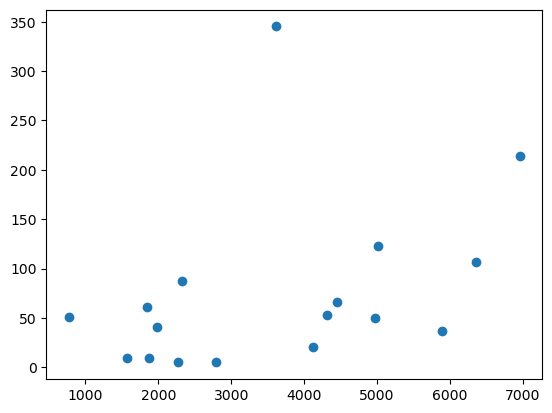

In [166]:
plt.scatter(distance.iloc[:,0],distance.iloc[:,1])

In [167]:
np.corrcoef(distance.iloc[:,0],distance.iloc[:,1])[0,1]

0.3799073603139398

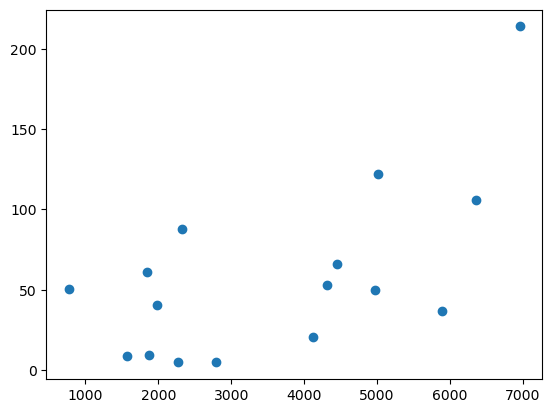

In [168]:
plt.scatter(distance.iloc[:,0].drop('09'),distance.iloc[:,1].drop('09'))


In [169]:
np.corrcoef(distance.iloc[:,0].drop('09'),distance.iloc[:,1].drop('09'))

array([[1.        , 0.62683642],
       [0.62683642, 1.        ]])

In [170]:
mode_weights = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

In [171]:
mode_weights=mode_weights.drop(15,axis=0)

In [172]:
mode_weights

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
3,14.528402,16.328970,-5.269040,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217


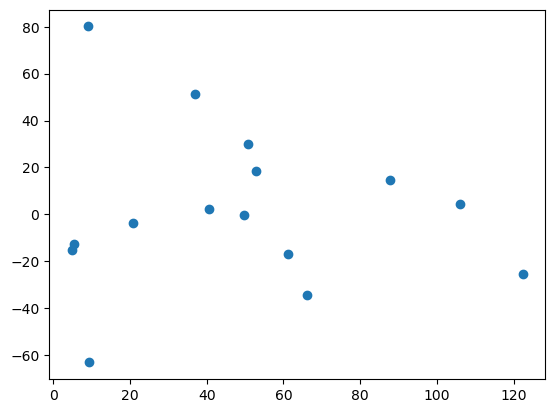

In [173]:
plt.scatter(distance.iloc[:,1].drop(['09','18']),mode_weights.iloc[1:,0].drop([9,18]))



In [174]:
corr_A=np.zeros(18)
corr_V=np.zeros(18)
for i in range(18):
    corr_A[i]=(np.corrcoef(distance.iloc[:,0].drop(['09','18']),mode_weights.iloc[1:,i].drop([9,18]))[0,1])
    corr_V[i]=(np.corrcoef(distance.iloc[:,1].drop(['09','18']),mode_weights.iloc[1:,i].drop([9,18]))[0,1])

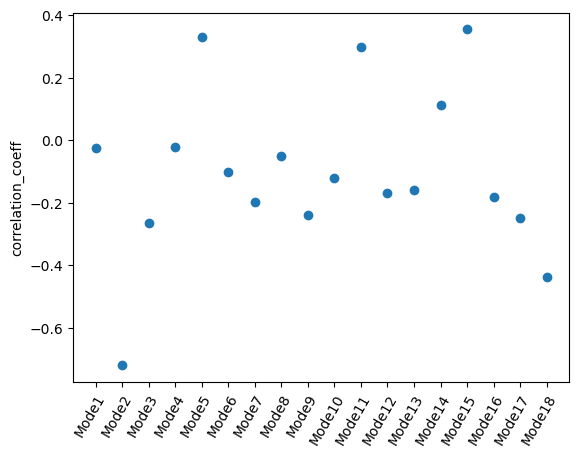

In [175]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_A)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

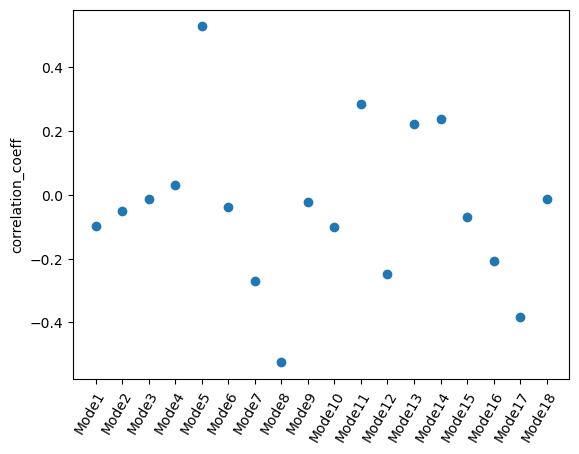

In [176]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_V)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [177]:
corr_A=np.zeros(18)
corr_V=np.zeros(18)
for i in range(18):
    corr_A[i]=(np.corrcoef(distance.iloc[:,0],mode_weights.iloc[1:,i])[0,1])
    corr_V[i]=(np.corrcoef(distance.iloc[:,1],mode_weights.iloc[1:,i])[0,1])

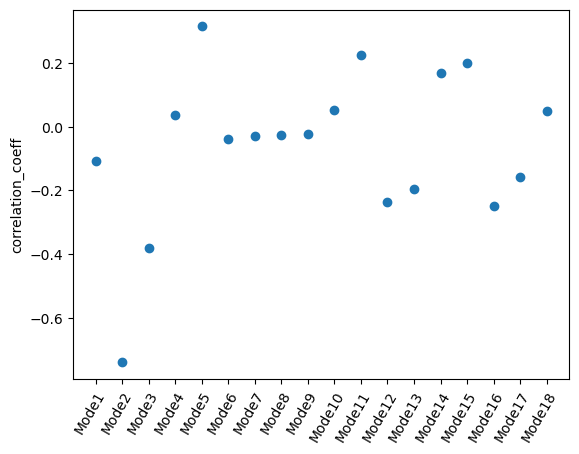

In [186]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_A)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

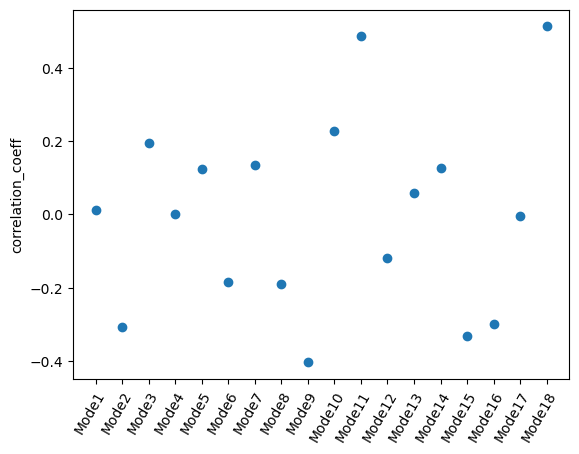

In [187]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_V)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [231]:
np.array(d)[:,:,0].shape

(18, 180)